<a href="https://colab.research.google.com/github/Guru2308/PR-CIA/blob/main/BCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#G-DRIVE Mount


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#IMPORTS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
import os
import random
import time

(250, 16, 60)


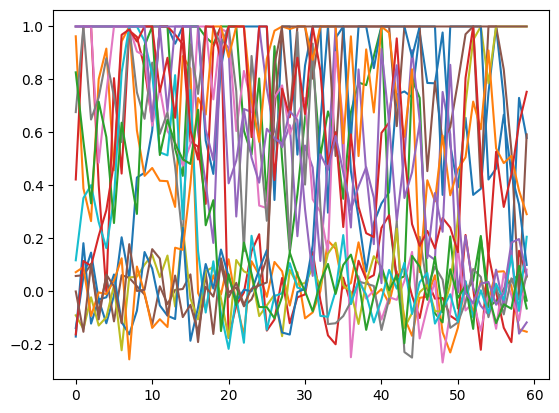

In [3]:
d = np.load("/content/gdrive/MyDrive/model_data/aug_data/left/augmented_1572814991.npy")
print(d.shape)
for channel in d[0]:
    plt.plot(channel)
plt.show()

#TRAINING

In [5]:
ACTIONS = ["left", "right", "none"]
reshape = (-1, 16, 60)

In [6]:
def create_data(starting_dir="/content/gdrive/MyDrive/model_data/aug_data"):
    training_data = {}
    for action in ACTIONS:
        if action not in training_data:
            training_data[action] = []

        data_dir = os.path.join(starting_dir,action)
        for item in os.listdir(data_dir):
            #print(action, item)
            data = np.load(os.path.join(data_dir, item))
            for item in data:
                training_data[action].append(item)

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)

    for action in ACTIONS:
        np.random.shuffle(training_data[action])  # note that regular shuffle is GOOF af
        training_data[action] = training_data[action][:min(lengths)]

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)
    # creating X, y
    combined_data = []
    for action in ACTIONS:
        for data in training_data[action]:

            if action == "left":
                combined_data.append([data, [1, 0, 0]])

            elif action == "right":
                #np.append(combined_data, np.array([data, [1, 0]]))
                combined_data.append([data, [0, 0, 1]])

            elif action == "none":
                combined_data.append([data, [0, 1, 0]])

    np.random.shuffle(combined_data)
    print("length:",len(combined_data))
    return combined_data

Creating training data

In [7]:
print("creating training data")
traindata = create_data(starting_dir="/content/gdrive/MyDrive/model_data/aug_data")
train_X = []
train_y = []
for X, y in traindata:
    train_X.append(X)
    train_y.append(y)

creating training data
[95125, 94125, 95375]
[94125, 94125, 94125]
length: 282375


Creating testing data

In [8]:
print("creating testing data")
testdata = create_data(starting_dir="/content/gdrive/MyDrive/model_data/validation_data")
test_X = []
test_y = []
for X, y in testdata:
    test_X.append(X)
    test_y.append(y)

creating testing data
[11750, 11750, 11750]
[11750, 11750, 11750]
length: 35250


In [9]:
print(len(train_X))
print(len(test_X))

282375
35250


In [10]:
print(np.array(train_X).shape)
train_X = np.array(train_X).reshape(reshape)
test_X = np.array(test_X).reshape(reshape)

(282375, 16, 60)


In [11]:
train_X = np.clip(np.array(train_X).reshape(reshape), -10, 10) / 10
test_X = np.clip(np.array(test_X).reshape(reshape), -10, 10) / 10

In [12]:
train_y = np.array(train_y)
test_y = np.array(test_y)

#BUILDING A MODEL

In [13]:
model = Sequential()

model.add(Conv1D(64, (3), input_shape=train_X.shape[1:]))
model.add(Activation('relu'))

model.add(Conv1D(128, (2)))
model.add(Activation('relu'))

model.add(Conv1D(128, (2)))
model.add(Activation('relu'))

model.add(Conv1D(64, (2)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Conv1D(64, (2)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=(2)))

model.add(Flatten())

model.add(Dense(512))
model.add(Dense(256))
model.add(Dense(128))

model.add(Dense(3))
model.add(Activation('softmax'))

#COMPILING A MODEL

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Fitting the model

In [15]:
model.fit(train_X, train_y, batch_size=64, epochs=10, validation_data=(test_X, test_y))

Epoch 1/10
1382/4413 [========>.....................] - ETA: 1:12 - loss: 1.0990 - accuracy: 0.3318

KeyboardInterrupt: ignored

#MODEL EVALUATION

In [27]:
accuracy = model.evaluate(test_X, test_y, batch_size=32)

1102/1102 [==============================] - 4s 4ms/step - loss: 3.2687 - accuracy: 0.3298


In [ ]:
model.save('bci.h5')

#TESTING AND MAKING DATA


IMPORTS


In [ ]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
MODEL_NAME = "/content/bci.h5"

In [ ]:
CLIP = True
CLIP_VAL = 10

Loading the model

In [ ]:
model = tf.keras.models.load_model(MODEL_NAME)

In [ ]:
VALDIR = '/content/gdrive/MyDrive/model_data/validation_data'
ACTIONS = ['left','none','right']
PRED_BATCH = 32

In [ ]:
def get_val_data(valdir, action, batch_size):

    argmax_dict = {0: 0, 1: 0, 2: 0}
    raw_pred_dict = {0: 0, 1: 0, 2: 0}

    action_dir = os.path.join(valdir, action)
    for session_file in os.listdir(action_dir):
        filepath = os.path.join(action_dir,session_file)
        if CLIP:
            data = np.clip(np.load(filepath), -CLIP_VAL, CLIP_VAL) / CLIP_VAL
        else:
            data = np.load(filepath)

        preds = model.predict([data.reshape(-1, 16, 60)], batch_size=batch_size)

        for pred in preds:
            argmax = np.argmax(pred)
            argmax_dict[argmax] += 1
            for idx,value in enumerate(pred):
                raw_pred_dict[idx] += value

    argmax_pct_dict = {}

    for i in argmax_dict:
        total = 0
        correct = argmax_dict[i]
        for ii in argmax_dict:
            total += argmax_dict[ii]

        argmax_pct_dict[i] = round(correct/total, 3)

    return argmax_dict, raw_pred_dict, argmax_pct_dict

In [ ]:
def make_conf_mat(left, none, right):

    action_dict = {"left": left, "none": none, "right": right}
    action_conf_mat = pd.DataFrame(action_dict)
    actions = [i for i in action_dict]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(action_conf_mat, cmap=plt.cm.RdYlGn)
    ax.set_xticklabels([""]+actions)
    ax.set_yticklabels([""]+actions)

    print("__________")
    print(action_dict)
    for idx, i in enumerate(action_dict):
        print('tf',i)
        for idx2, ii in enumerate(action_dict[i]):
            print(i, ii)
            print(action_dict[i][ii])
            ax.text(idx, idx2, f"{round(float(action_dict[i][ii]),2)}", va='center', ha='center')
    plt.title("Action Thought")
    plt.ylabel("Predicted Action")
    plt.show()

In [ ]:
left_argmax_dict, left_raw_pred_dict, left_argmax_pct_dict = get_val_data(VALDIR, "left", PRED_BATCH)
none_argmax_dict, none_raw_pred_dict, none_argmax_pct_dict = get_val_data(VALDIR, "none", PRED_BATCH)
right_argmax_dict, right_raw_pred_dict, right_argmax_pct_dict = get_val_data(VALDIR, "right", PRED_BATCH)

8/8 [==============================] - 0s 4ms/step


<ipython-input-8-4e665164aa54>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+actions)
<ipython-input-8-4e665164aa54>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+actions)


__________
{'left': {0: 0.425, 1: 0.037, 2: 0.538}, 'none': {0: 0.44, 1: 0.081, 2: 0.479}, 'right': {0: 0.498, 1: 0.023, 2: 0.479}}
tf left
left 0
0.425
left 1
0.037
left 2
0.538
tf none
none 0
0.44
none 1
0.081
none 2
0.479
tf right
right 0
0.498
right 1
0.023
right 2
0.479


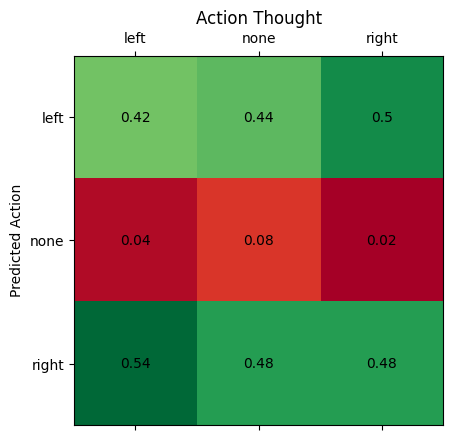

In [ ]:
make_conf_mat(left_argmax_pct_dict, none_argmax_pct_dict, right_argmax_pct_dict)

Augmentation


In [4]:
import numpy as np
import os
from scipy.ndimage import shift
import shutil

# Function to augment EEG data
def augment_eeg_data(signal, time_shift_range=50, max_noise=0.1):
    num_time_steps = len(signal)

    # Time Shifting
    time_shift = np.random.randint(-time_shift_range, time_shift_range)
    if time_shift >= 0:
        shifted_signal = np.concatenate((signal[time_shift:], np.zeros(time_shift)))
    else:
        shifted_signal = np.concatenate((np.zeros(-time_shift), signal[:num_time_steps + time_shift]))

    # Random Noise Addition
    noise = np.random.normal(scale=max_noise, size=num_time_steps)
    augmented_signal = np.clip(shifted_signal + noise, -1, 1)

    return augmented_signal

# Load EEG signals from the source directory
source_directory = '/content/gdrive/MyDrive/model_data/data/left'  # Replace with the path to your source directory
target_directory = '/content/gdrive/MyDrive/model_data/aug_data/left'  # Replace with the path to your target directory

if not os.path.exists(target_directory):
    os.makedirs(target_directory)

file_list = os.listdir(source_directory)

for filename in file_list:
    if filename.endswith('.npy'):
        # Load the EEG signal from the .npy file
        file_path = os.path.join(source_directory, filename)
        eeg_signal = np.load(file_path)

        # Perform data augmentation
        augmented_signal = augment_eeg_data(eeg_signal)

        # Save the augmented data to the target directory
        target_file_path = os.path.join(target_directory, f"augmented_{filename}")
        np.save(target_file_path, augmented_signal)

print("Data augmentation completed and augmented data saved to the target directory.")

ValueError: ignored

In [10]:
import numpy as np
import os
from scipy.ndimage import shift
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Function to augment EEG data
def augment_eeg_data(eeg_data, time_shift_range=50, max_noise=0.1):
    augmented_data = []

    for signal in eeg_data:
        num_channels, num_time_steps = signal.shape
        augmented_signal = np.empty_like(signal)

        # Loop through channels
        for channel in range(num_channels):
            # Time Shifting
            time_shift = np.random.randint(-time_shift_range, time_shift_range)
            if time_shift >= 0:
                shifted_signal = np.concatenate((signal[channel, time_shift:], np.zeros(time_shift)))
            else:
                shifted_signal = np.concatenate((np.zeros(-time_shift), signal[channel, :num_time_steps + time_shift]))

            # Random Noise Addition
            noise = np.random.normal(scale=max_noise, size=num_time_steps)
            augmented_channel = np.clip(shifted_signal + noise, -1, 1)

            augmented_signal[channel, :] = augmented_channel

        augmented_data.append(augmented_signal)

    return np.array(augmented_data)

# Load EEG signals from the source directory in Google Drive
source_directory = '/content/gdrive/MyDrive/model_data/data/none'
target_directory = '/content/gdrive/MyDrive/model_data/aug_data/none'

if not os.path.exists(target_directory):
    os.makedirs(target_directory)

file_list = os.listdir(source_directory)

for filename in file_list:
    if filename.endswith('.npy'):
        # Load the EEG signals from the .npy file
        file_path = os.path.join(source_directory, filename)
        eeg_signals = np.load(file_path)

        # Perform data augmentation
        augmented_signals = augment_eeg_data(eeg_signals)

        # Save the augmented data to the target directory
        target_file_path = os.path.join(target_directory, f"augmented_{filename}")
        np.save(target_file_path, augmented_signals)

print("Data augmentation completed, and augmented data saved to the target directory.")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Data augmentation completed, and augmented data saved to the target directory.


61 acc


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, BatchNormalization, Reshape
from tensorflow.keras import regularizers
import os
import random
import time

DATASEP = 5

ACTIONS = ["left", "right", "none"]
reshape = (-1, 16, 60)

def create_data(starting_dir="data"):
    training_data = {}
    for action in ACTIONS:
        if action not in training_data:
            training_data[action] = []

        data_dir = os.path.join(starting_dir,action)
        for item in os.listdir(data_dir):
            #print(action, item)
            data = np.load(os.path.join(data_dir, item))
            for idx, item in enumerate(data):
            	# adding this for cushion between insample data.
            	if idx % DATASEP == 0:
                	training_data[action].append(item)

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)

    for action in ACTIONS:
        np.random.shuffle(training_data[action])
        training_data[action] = training_data[action][:min(lengths)]

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)
    # creating X, y
    combined_data = []
    for action in ACTIONS:
        for data in training_data[action]:

            if action == "left":
                combined_data.append([data, [1, 0, 0]])

            elif action == "right":
                #np.append(combined_data, np.array([data, [1, 0]]))
                combined_data.append([data, [0, 0, 1]])

            elif action == "none":
                combined_data.append([data, [0, 1, 0]])

    np.random.shuffle(combined_data)
    print("length:",len(combined_data))
    return combined_data

print("creating training data")
traindata = create_data(starting_dir="/content/gdrive/MyDrive/model_data/aug_data/")
train_X = []
train_y = []
for X, y in traindata:
    train_X.append(X)
    train_y.append(y)

print("creating testing data")
testdata = create_data(starting_dir="/content/gdrive/MyDrive/model_data/validation_data")
test_X = []
test_y = []
for X, y in testdata:
    test_X.append(X)
    test_y.append(y)

print(len(train_X))
print(len(test_X))

print(np.array(train_X).shape)

train_X = np.clip(np.array(train_X).reshape(reshape) - np.mean(train_X), -10, 10) / 10
test_X = np.clip(np.array(test_X).reshape(reshape) - np.mean(test_X), -10, 10) / 10

train_y = np.array(train_y)
test_y = np.array(test_y)


model = Sequential()

model.add(Conv1D(64, (5), padding='same', input_shape=train_X.shape[1:]))
model.add(Activation('relu'))

model.add(Conv1D(128, (5), padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(256, (5), padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(512, (5), padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(3, (16)))
model.add(Reshape((3,)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

epochs = 10
batch_size = 32
for epoch in range(epochs):
    model.fit(train_X, train_y, batch_size=batch_size, epochs=1, validation_data=(test_X, test_y))
    score = model.evaluate(test_X, test_y, batch_size=batch_size)
    print(score)

creating training data
[19025, 18825, 19075]
[18825, 18825, 18825]
length: 56475
creating testing data
[2350, 2350, 2350]
[2350, 2350, 2350]
length: 7050
56475
7050
(56475, 16, 60)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 16, 64)            19264     
                                                                 
 activation_6 (Activation)   (None, 16, 64)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 16, 128)           41088     
                                                                 
 activation_7 (Activation)   (None, 16, 128)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 16, 256)           164096    
                                                                 
 acti

In [18]:
accuracy = model.evaluate(test_X, test_y, batch_size=32)

221/221 [==============================] - 5s 24ms/step - loss: 10.7251 - accuracy: 0.3660
